In [1]:
from typing import Dict, List, Tuple, Set
from utils import *

def center_of_centers(distances: List[List[float]], client_locations: List[List[int]], k: int):
    
    clients = []
    
    for client in client_locations:
        
        dispersion = 1e10
        effective_center = -1
        
        for center in client:
            
            max_dist = 0
            
            for loc in client:
                max_dist = max(distances[center][loc], max_dist)
                
            if max_dist < dispersion:
                dispersion = max_dist
                effective_center = center
                
        clients.append(effective_center)
        
    homes = [locs[0] for locs in client_locations]
    locations = [i for i in range(len(distances)) if i not in homes]
    facilities = _k_supplier(distances, clients, locations, k)
    
    return facilities, assign_facilities(G, [locs[:1] for locs in client_locations], facilities)
    

def _k_supplier(distances: List[List[int]], clients: List[int], locations: List[int], k: int):
    
    #set the radius to ensure there exists a facility within radius r of each client
    max_min_dist = max([min([cost(distances, c, f) for f in locations]) for c in clients])
    
    possible_OPT = [i for k in distances for i in k if i>=max_min_dist]
    possible_OPT.sort()
    
    l = 0;
    r = len(possible_OPT)-1
    to_ret = -1
    pairwise_disjoint = set()
    
    while l <= r:
  
        mid = l + (r - l) // 2;
        
        pairwise_disjoint =  _check_radius(possible_OPT[mid], distances, clients, locations, k)
        if len(pairwise_disjoint) <= k:
            r = mid - 1
            to_ret = mid
        else:
            l = mid + 1
        
    if to_ret >= 0:
        facilities = _locate_facilities(possible_OPT[to_ret], distances, pairwise_disjoint, locations, k)
        return facilities
    else:
        print("NO SOLUTION")

def _check_radius(radius: int, distances: List[List[int]], clients: List[int], locations: List[int], k: int):
    
    pairwise_disjoint = set()
    
    V = set(clients)
    while len(V)!=0:
        v = V.pop()
        pairwise_disjoint.add(v)
        remove = set()
        for i in V:
            if cost(distances,v,i) <= 2*radius:
                remove.add(i)
        V-=remove
    
    return pairwise_disjoint


def _locate_facilities(radius: int, distances: List[List[int]], pairwise_disjoint: Set[int], locations: List[int], k: int):
    
    facilities = set()
    for c in pairwise_disjoint:
        for l in locations:
            if cost(distances, c, l) <= 2*radius:
                facilities.add(l)
                break
    
    #Check if k is too large
    k = min(k, len(locations))
    
    #If there are more facilities to open
    if k>len(facilities):
        unopened_facilities = set(locations)-facilities
        for i in range(k-len(facilities)):
            facilities.add(unopened_facilities.pop())
    return list(facilities)

In [1]:
from config import LOCATIONS, CLIENT_LOCATIONS, HOME_SHIFT
from utils import *
import time
import geopy

In [8]:
LOCATIONS[0]

{'lid': 82889,
 'longitude': -78.47261,
 'latitude': 38.0593000000001,
 'activity': 5609,
 'pid': [5603328,
  5603334,
  5603337,
  5603343,
  5603347,
  5603348,
  5603362,
  5603369,
  5603380,
  5603385,
  5603399,
  5603419,
  5603420,
  5603424,
  5603447,
  5603451,
  5603455,
  5603461,
  5603468,
  5603481,
  5603493,
  5603505,
  5603511,
  5603515,
  5603517,
  5603525,
  5603529,
  5603579,
  5603584,
  5603589,
  5603594,
  5603605,
  5603606,
  5603610,
  5603616,
  5603621,
  5603634,
  5603636,
  5603647,
  5603649,
  5603656,
  5603657,
  5603665,
  5603685,
  5603694,
  5603709,
  5603716,
  5603718,
  5603727,
  5603750,
  5603756,
  5603758,
  5603759,
  5603784,
  5603788,
  5603792,
  5603807,
  5603825,
  5603828,
  5603835,
  5603858,
  5603866,
  5603874,
  5603878,
  5603881,
  5603893,
  5603898,
  5603900,
  5603906,
  5603910,
  5603915,
  5603918,
  5603921,
  5603924,
  5603930,
  5603939,
  5603953,
  5603965,
  5603969,
  5603972,
  5603982,
  5603983,
 

In [12]:
activity_locations = []

for k,v in LOCATIONS.items():
    if v['lid'] < HOME_SHIFT:
        activity_locations.append((k, v['longitude'],v['latitude']))

In [31]:
start = time.time()

close_locations = []

for i in range(len(activity_locations)):
    
    for j in range(i, len(activity_locations)):
        
        loc1 = activity_locations[i]
        loc2 = activity_locations[j]
        
        distance = calculate_distance(loc1[0], loc2[0])
        
        if distance <= .01:
            close_locations.append((loc1[0], loc2[0], distance))

time1 = time.time()-start 
print(time1)


461.69948077201843


In [26]:
len(close_locations)

11114

In [28]:
locs = set()
for a in close_locations:
    locs.add(a[0])
    locs.add(a[1])
    
print(len(locs))

4254


In [36]:
cover = {}

for pair in close_locations:
    
    if pair[0] in cover:
        cover[pair[0]].add(pair[1])
    else:
        cover[pair[0]] = {pair[1]}
    
    if pair[1] in cover:
        cover[pair[1]].add(pair[0])
    else:
        cover[pair[1]] = {pair[0]}

In [37]:
type({0})

set

In [42]:
len(activity_locations)

9165

In [41]:
rep = []
cover_rep = set()

i = 0

while len(cover_rep) != len(activity_locations):
    
    pick = -1
    extra_in_pick = -1
    
    for (k,v) in cover.items():
        extra = v-cover_rep
        
        if len(extra) > extra_in_pick:
            pick = k
            extra_in_pick = len(extra)
    
    rep.append(pick)
    cover_rep = cover_rep.union(cover[pick])
    print(i)
    i+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066


3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929


5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620
5621
5622
5623
5624
5625
5626
5627
5628
5629
5630
5631
5632
5633
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666
5667
5668
5669
5670
5671
5672
5673
5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
5684
5685
5686
5687
5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723
5724
5725
5726
5727
5728
5729
5730
5731
5732
5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748
5749
5750
5751
5752
5753
5754
5755
5756
5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767
5768
5769
5770


In [43]:
len(rep)

6176

In [46]:
len(activity_locations)

9165

In [47]:
9165-6176

2989

In [49]:
len(LOCATIONS)-2989

16214

In [22]:
1.397531509399414/0.07591009140014648

18.410352083922234

In [20]:
def calculate_distance2(loc1: int, loc2: int):
    """
    Calculates the haversine distance between two location indices
    """
    coord1_row = LOCATIONS[loc1]
    coord2_row = LOCATIONS[loc2]
    coord1 = (coord1_row['latitude'], coord1_row['longitude'])
    coord2 = (coord2_row['latitude'], coord2_row['longitude'])
    return geopy.distance.distance(coord1, coord2).km

In [2]:
G = [[0], [5, 0], [12, 7, 0]]
clients = [[0], [2]]
k = 1
center_of_centers(G, clients, k)

([1], [(0, 1), (2, 1)])

In [3]:
distances = [[5,6,7,8],[1,2,3,4],[8]]

possible_OPT = [i for k in distances for i in k]

print(possible_OPT)

possible_OPT.sort()

print(possible_OPT)

[5, 6, 7, 8, 1, 2, 3, 4, 8]
[1, 2, 3, 4, 5, 6, 7, 8, 8]


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

assignments = pd.read_csv("usa_va_charlottesville_city_adult_activity_location_assignment_week.csv")

locations = pd.read_csv("usa_va_charlottesville_city_activity_locations.csv")

residents = pd.read_csv("usa_va_charlottesville_city_residence_locations.csv") 

In [6]:
assignments.head()

hid      pid  activity_number  activity_type  start_time  duration  \
0  2208253  5586585                0              1           0     27900   
1  2208253  5586585                2              2       28800     17100   
2  2208253  5586585                4              4       46800      1200   
3  2208253  5586585                6              2       48600     15300   
4  2208253  5586585                8              1       64800     36000   

       lid  longitude   latitude  travel_mode  
0  1018209 -78.488467  38.043025           -1  
1    82246 -78.414920  38.157530           -1  
2    86726 -78.498790  38.139160           -1  
3    82246 -78.414920  38.157530           -1  
4  1018209 -78.488467  38.043025           -1

In [4]:
assignments['lid'].value_counts()

77571     12026
127361     7817
82889      7678
91203      7672
130369     7672
          ...  
2635          1
94823         1
96870         1
86627         1
14329         1
Name: lid, Length: 18455, dtype: int64

In [7]:
locations['alid'].value_counts()

86018     1
701       1
96946     1
2740      1
115381    1
         ..
79140     1
116618    1
42270     1
23833     1
90108     1
Name: alid, Length: 9165, dtype: int64

In [9]:
residents['rlid'].value_counts()

280577     1
412332     1
201375     1
991905     1
228002     1
          ..
2127164    1
359741     1
912703     1
1889600    1
280575     1
Name: rlid, Length: 10038, dtype: int64

In [43]:
locations.head()

alid  longitude  latitude  altitude  admin1  admin2  admin3  admin4  work  \
0    15  -78.43559  38.13181        -1      51       3   10300       1     1   
1    16  -77.96971  38.48384        -1      51      47  930300       1     1   
2    71  -77.48025  37.57647        -1      51      87  200502       2     1   
3    88  -78.47990  38.07682        -1      51       3   10700       1     1   
4    89  -78.46760  38.04057        -1      51     540     900       2     1   

   shopping  school  other  college  religion  designation  
0       400       0      1        0         0  none:retail  
1      1437       0      1        0         0  none:retail  
2      5000       0      1        0         0  none:retail  
3       914       0      1        0         0  none:retail  
4       139       0      1        0         0  none:retail

In [61]:
locations['activity'] = locations['work'] + locations['shopping'] + locations['school'] + locations['other'] + locations['college'] + locations['religion']

In [62]:
locations = locations.sort_values(by="activity", ascending=False)

In [63]:
locations = locations.reset_index(drop=True)

In [55]:
locations = locations[locations.work != 5000].reset_index(drop=True)
locations = locations[locations.shopping != 5000].reset_index(drop=True)
locations = locations[locations.school != 5000].reset_index(drop=True)
locations = locations[locations.other != 5000].reset_index(drop=True)
locations = locations[locations.college != 5000].reset_index(drop=True)
locations = locations[locations.religion != 5000].reset_index(drop=True)


In [65]:
locations.head(20)

alid  longitude   latitude  altitude  admin1  admin2  admin3  admin4  \
0    77522 -79.179688  37.350345        -1      51     680    1400       1   
1    77537 -77.236679  38.834039        -1      51      59  440800       3   
2    77513 -77.307940  38.830880        -1      51      59  440502       1   
3    77570 -77.453597  37.547631        -1      51     760   40300       1   
4    77571 -78.503428  38.035665        -1      51       3   10903       2   
5    77519 -78.870484  38.436311        -1      51     660     206       1   
6    77496 -76.708214  37.269489        -1      51     830  370100       2   
7    77518 -77.472958  37.637415        -1      51      87  200801       1   
8   133755 -77.189920  38.819140        -1      51      59  452102       1   
9    83020 -77.533670  38.908490        -1      51     107  611802       2   
10  105775 -77.380400  37.471870        -1      51      87  201501       1   
11   89617 -77.138080  38.701150        -1      51      59  416200       2   
12  115680 -78.865750  38.459100        -1      51     660     402       5   
13  105728 -77.424180  39.019430        -1      51     107  611502       1   
14   99187 -77.482060  39.016760        -1      51     107  611019       2   
15   83008 -77.106500  38.867010        -1      51      13  102301       2   
16   95126 -77.361630  37.515190        -1      51      87  201501       1   
17   95064 -77.374990  39.023200        -1      51     107  611205       2   
18  105469 -77.461210  39.033780        -1      51     107  611018       1   
19  127625 -78.542460  38.044810        -1      51       3   11000       2   

    work  shopping  school  other  college  religion             designation  \
0   5755         0       0      0    75756         0               education   
1   2415         0       0      0    50835         0               education   
2   4290         0       0      0    34909         0               education   
3   6278         0       0      0    30872         0               education   
4   8921         0       0      0    23898         0               education   
5   3269         0       0      0    21270         0               education   
6   2511         0       0      0     8617         0               education   
7    651         0       0      0    10375         0               education   
8   5000         0       0   5000        0         0            none:medical   
9   5000         0       0   5000        0         0            none:medical   
10  5000         0       0   5000        0         0            none:medical   
11  5000         0       0   5000        0         0            none:medical   
12  5000         0       0   5000        0         0            none:medical   
13  5000         0       0   5000        0         0            none:medical   
14  5000         0       0   5000        0         0            none:medical   
15  5000         0       0   5000        0         0           none:military   
16  5000         0       0   5000        0         0            none:medical   
17  5000         0       0   5000        0         0            none:medical   
18  5000         0       0   5000        0         0  none:care_facilitation   
19  5000         0       0   5000        0         0            none:medical   

    activity  
0      81511  
1      53250  
2      39199  
3      37150  
4      32819  
5      24539  
6      11128  
7      11026  
8      10000  
9      10000  
10     10000  
11     10000  
12     10000  
13     10000  
14     10000  
15     10000  
16     10000  
17     10000  
18     10000  
19     10000

In [87]:
locs = list(locations['alid'])
locs.sort()

In [88]:
locs

[15,
 16,
 71,
 88,
 89,
 130,
 141,
 144,
 145,
 159,
 196,
 232,
 233,
 234,
 239,
 251,
 256,
 270,
 285,
 320,
 325,
 348,
 350,
 352,
 438,
 440,
 448,
 449,
 450,
 451,
 456,
 461,
 475,
 476,
 478,
 517,
 539,
 542,
 543,
 574,
 575,
 576,
 577,
 578,
 595,
 596,
 623,
 645,
 649,
 650,
 673,
 675,
 690,
 701,
 745,
 767,
 768,
 779,
 784,
 788,
 808,
 835,
 836,
 839,
 840,
 863,
 874,
 875,
 904,
 908,
 913,
 915,
 916,
 918,
 947,
 951,
 956,
 969,
 987,
 989,
 994,
 997,
 1011,
 1040,
 1041,
 1066,
 1072,
 1075,
 1093,
 1103,
 1109,
 1122,
 1203,
 1237,
 1238,
 1247,
 1271,
 1272,
 1289,
 1307,
 1322,
 1335,
 1347,
 1352,
 1372,
 1384,
 1385,
 1445,
 1458,
 1493,
 1501,
 1522,
 1543,
 1544,
 1545,
 1546,
 1547,
 1548,
 1550,
 1600,
 1609,
 1610,
 1611,
 1612,
 1622,
 1624,
 1643,
 1654,
 1655,
 1656,
 1657,
 1658,
 1680,
 1688,
 1691,
 1702,
 1727,
 1733,
 1734,
 1735,
 1736,
 1738,
 1745,
 1754,
 1755,
 1771,
 1774,
 1775,
 1783,
 1788,
 1817,
 1830,
 1846,
 1911,
 1978,
 1

[]

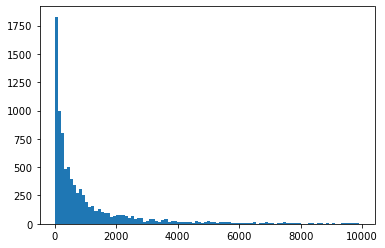

In [57]:
plt.hist(locations[10:]['activity'], bins=100)
plt.plot()

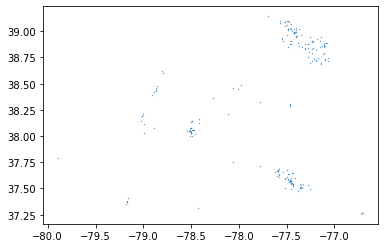

In [76]:
num_points = 200
plt.scatter(x=locations[:num_points]['longitude'],y=locations[:num_points]['latitude'], s=0.1)

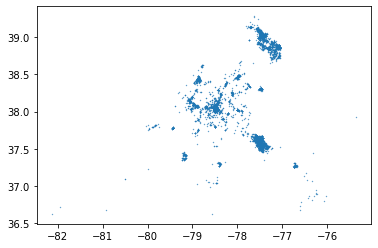

In [37]:
plt.scatter(x=locations['longitude'],y=locations['latitude'], s=0.1)

In [30]:
residents.head()

rlid  longitude   latitude  altitude  admin1  admin2  admin3  admin4  \
0  17044 -78.475050  38.066151        -1      51     540     800       1   
1  17046 -78.473818  38.069160        -1      51     540     800       1   
2  17061 -78.497536  38.059734        -1      51     540     800       4   
3  17063 -78.498064  38.060366        -1      51     540     800       4   
4  17064 -78.486814  38.060308        -1      51     540     800       4   

   area_sqm  associate_link_func_class  ...  pub_03  pub_04  pub_05  pub_06  \
0       169                          5  ...   77881   77881   77883   77883   
1       171                          5  ...   77881   77881   77883   77883   
2       263                          5  ...   77885   77885   77883   77883   
3       156                          5  ...   77881   77881   77883   77883   
4       248                          5  ...   77881   77881   77883   77883   

   pub_07  pub_08  pub_09  pub_10  pub_11  pub_12  
0   77688   77688   77880   77880   77880   77880  
1   77688   77688   77880   77880   77880   77880  
2   77672   77672   77880   77880   77880   77880  
3   77672   77672   77880   77880   77880   77880  
4   77688   77688   77880   77880   77880   77880  

[5 rows x 24 columns]

In [77]:
residents.columns

Index(['rlid', 'longitude', 'latitude', 'altitude', 'admin1', 'admin2',
       'admin3', 'admin4', 'area_sqm', 'associate_link_func_class', 'pub_pk',
       'pub_kg', 'pub_01', 'pub_02', 'pub_03', 'pub_04', 'pub_05', 'pub_06',
       'pub_07', 'pub_08', 'pub_09', 'pub_10', 'pub_11', 'pub_12'],
      dtype='object')

In [31]:
residents.shape

(10038, 24)

In [28]:
%load_ext autoreload
%autoreload 2

%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
%load_ext autoreload
%autoreload 2

from utils import *
from heuristics import _k_supplier
import geopy
import math
import time
from joblib import Parallel, delayed


def fpt2_parallel(k: int, s: int):
    """
    Assumes the number of locations visited by clients is bounded by a constant
    Run k-supplier on all combination sets of locations that will be covered by facilities. Select the guess and its open facilities with the smallest objective value.
    
    PARAMETERS
    ----------
    k : int
        number of facilities to be opened
    
    RETURNS
    ----------
    facilities : List[int]
        contains facility indices that are open
    assignments : List[Tuple[int, int]]
        visited location and facility assignment indexed by each client
    """
    potential_facility_locations = list(range(s))
    
    #Remove homes from the client_location lists
    #TODO: Perhaps create mapping for the indices of people before exclusion and after?
    client_locations_excluded = []
    for person in CLIENT_LOCATIONS.values():
        new_list = [p for p in person['lid'][1:] if p in potential_facility_locations]
        if len(new_list)>0:
            client_locations_excluded.append(new_list)
    
    locations = [i for i in range(len(LOCATIONS)) if LOCATIONS[i]['lid'] < HOME_SHIFT]
    
    G, loc_map, c_loc_map = precompute_distances(client_locations_excluded, locations)
    
    def process(guess):
        facilities = _k_supplier(list(guess), locations, k)
        obj_value = assign_client_facilities2(G, loc_map, c_loc_map, client_locations_excluded, facilities)
        
        return obj_value, facilities

    results = Parallel(n_jobs=16)(delayed(process)(guess) for guess in powerset(list(potential_facility_locations)))
    
    min_obj_guess: Tuple[int, List[int]] = min(results)
    return min_obj_guess, assign_facilities(min_obj_guess[1])

In [19]:
from heuristics import *

In [5]:
(val, asgn) = fpt3_parallel2(5, 15, 0)

COVERAGE OF CLIENTS BY 15 LOCATIONS:  0.8028109542767523


2021-08-17 19:20:15,752	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


KeyboardInterrupt: 

In [6]:
calculate_objective(asgn)

2.3956977875908194

In [20]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range((len(s)+1)//2,-1,-1))

In [29]:
print([i for i in range(1,5)])

[1, 2, 3, 4]


In [7]:
from heuristics import *

fac1, asgn1 = center_of_homes(5)
print(calculate_objective(asgn1))


1.993687977423548


In [9]:
home_obj = [calculate_percentile_objective(asgn1, i/100) for i in range(50,101,1)]

In [8]:
fac2, asgn2 = center_of_centers(5)
print(calculate_objective(asgn2))

6.395545048189607


In [10]:
center_obj = [calculate_percentile_objective(asgn2, i/100) for i in range(50,101,1)]

In [12]:
import matplotlib.pyplot as plt
x = [i for i in range(50,101,1)]

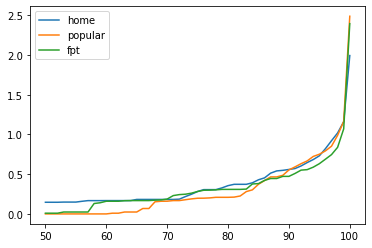

In [46]:
plt.plot(x, home_obj, label='home')
#plt.plot(x, center_obj, label='center')
plt.plot(x, pop_obj, label='popular')
plt.plot(x, fpt_obj, label='fpt')
plt.legend()

In [41]:
import json
with open("fpt_exp_sensitivity_0.json", 'r') as file:
    j = json.load(file)
    
    asgn4 = j['(5, 15)']['assignments']
    
#fpt_obj = [calculate_percentile_objective(asgn4, i/100) for i in range(50,101,1)]

with open("fpt_exp_sensitivity_1.json", 'r') as file:
    j = json.load(file)
    
    asgn5 = j['(5, 20)']['assignments']
    
fpt_obj = [calculate_percentile_objective(asgn5, i/100) for i in range(50,101,1)]

In [44]:
fac3, asgn3 = most_populous_agg(5, 1)
pop_obj = [calculate_percentile_objective(asgn3, i/100) for i in range(50,101,1)]

In [21]:
def most_populous(k: int):
    return list(range(k)), assign_facilities(list(range(k)))

In [ ]:
def center_of_centers2(k: int):
    """
    PARAMETERS
    ----------
    k : int
        number of facilities to be opened
    
    RETURNS
    ----------
    facilities : List[int]
        contains facility indices that are open
    assignments : List[Tuple[int, int]]
        visited location and facility assignment indexed by each client
    """
    clients = []
    
    for client_row in CLIENT_LOCATIONS.values():
        
        client = client_row["lid"]
        
        dispersion = 1e10
        effective_center = -1
        
        for center in client:
            
            max_dist = 0
            
            for loc in client:
                max_dist = max(calculate_distance(center, loc), max_dist)
                
            if max_dist < dispersion:
                dispersion = max_dist
                effective_center = center
                
        clients.append(effective_center)
        
    locations = [i for i in range(len(LOCATIONS)) if LOCATIONS[i]['lid'] < HOME_SHIFT]
    facilities = _k_supplier(clients, locations, k)
    
    return facilities, assign_facilities(facilities)